In [14]:
import pandas as pd
import CococoNet_reader
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns


In [15]:
arabi_csv_uncleaned = pd.read_csv(
    "/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/arabi_data/GSE94015_gene_readCount.txt",
    sep="\t",
)
arabi_csv = arabi_csv_uncleaned[
    [
        "Locus",
        "WtRL0h_rep1",
        "WtRL0h_rep2",
        "WtRL0h_rep3",
        "WtRL3h_rep1",
        "WtRL3h_rep2",
        "WtRL3h_rep3",
    ]
]

arabi_csv = arabi_csv.set_index('Locus')
arabi_csv


,WtRL0h_rep1,WtRL0h_rep2,WtRL0h_rep3,WtRL3h_rep1,WtRL3h_rep2,WtRL3h_rep3
Locus,,,,,,
AT1G01010,92,212,255,79,154,169
AT1G01020,120,288,219,219,354,597
AT1G01030,3,28,15,5,9,14
AT1G01040,889,2127,2189,1041,1788,1807
AT1G01046,12,51,37,8,26,19
...,...,...,...,...,...,...
ATMG01370,18,59,67,218,382,249
ATMG01380,13,8,14,104,136,107
ATMG01390,382,1046,4054,5581,8779,4796


In [16]:
arabi_metadata = pd.DataFrame(
    columns=["Temp"],
    data=["Cold", "Cold", "Cold", "Hot", "Hot", "Hot"],
    index=[
        "WtRL0h_rep1",
        "WtRL0h_rep2",
        "WtRL0h_rep3",
        "WtRL3h_rep1",
        "WtRL3h_rep2",
        "WtRL3h_rep3",
    ],
)

In [17]:
low_heat_tomato_1 = pd.read_csv(
    "/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/low_heat_tomato/tomato_no_heat_stress_1ReadsPerGene.out.tab",
    sep="\t",
    index_col=0,
    skiprows=4,
    header=None,
    names=["Reads", "Left Reads", "Right reads"],
)
low_heat_tomato_2 = pd.read_csv(
    "/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/low_heat_tomato/tomato_no_heat_stress_2ReadsPerGene.out.tab",
    sep="\t",
    index_col=0,
    skiprows=4,
    header=None,
    names=["Reads", "Left Reads", "Right reads"],
)
low_heat_tomato_3 = pd.read_csv(
    "/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/low_heat_tomato/tomato_no_heat_stress_3ReadsPerGene.out.tab",
    sep="\t",
    index_col=0,
    skiprows=4,
    header=None,
    names=["Reads", "Left Reads", "Right reads"],
)

low_heat_tomato = pd.DataFrame(
    data=zip(
        low_heat_tomato_1["Reads"],
        low_heat_tomato_2["Reads"],
        low_heat_tomato_3["Reads"],
    ),
    columns=["Tom Cold Rep 1", "Tom Cold Rep 2", "Tom Cold Rep 3"],
    index=low_heat_tomato_1.index,
)


In [18]:
high_heat_tomato_rep_1 = pd.read_csv(
    "/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/high_heat_tomato/tomato_heat_stress_1ReadsPerGene.out.tab",
    sep="\t",
    index_col=0,
    skiprows=4,
    header=None,
    names=["Reads", "Left Reads", "Right reads"],
)
high_heat_tomato_rep_2 = pd.read_csv(
    "/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/high_heat_tomato/tomato_heat_stress_2ReadsPerGene.out.tab",
    sep="\t",
    index_col=0,
    skiprows=4,
    header=None,
    names=["Reads", "Left Reads", "Right reads"],
)
high_heat_tomato_rep_3 = pd.read_csv(
    "/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/high_heat_tomato/tomato_heat_stress_3ReadsPerGene.out.tab",
    sep="\t",
    index_col=0,
    skiprows=4,
    header=None,
    names=["Reads", "Left Reads", "Right reads"],
)
high_heat_tomato = pd.DataFrame(
    data=zip(
        high_heat_tomato_rep_1["Reads"],
        high_heat_tomato_rep_2["Reads"],
        high_heat_tomato_rep_3["Reads"],
    ),
    columns=["Tom Hot Rep 1", "Tom Hot Rep 2", "Tom Hot Rep 3"],
    index=low_heat_tomato_1.index,
)

In [19]:
combined_tomato = pd.concat([high_heat_tomato, low_heat_tomato], axis=1)

In [20]:
combined_tomato = combined_tomato.T
arabi_csv = arabi_csv.T



In [21]:
tomato_metadata = pd.DataFrame(
    columns=["Temp"],
    data=["Hot", "Hot", "Hot", "Cold", "Cold", "Cold"],
    index=[
        "Tom Hot Rep 1",
        "Tom Hot Rep 2",
        "Tom Hot Rep 3",
        "Tom Cold Rep 1",
        "Tom Cold Rep 2",
        "Tom Cold Rep 3",
    ],
)

In [22]:
genes_to_keep_arabi = arabi_csv.columns[arabi_csv.sum(axis=0) >= 100]
arabi_csv = arabi_csv[genes_to_keep_arabi]
inference_arabi = DefaultInference(n_cpus=30)
dds_arabi = DeseqDataSet(
    counts=arabi_csv,
    metadata=arabi_metadata,
    design_factors="Temp",
    refit_cooks=True,
    inference=inference_arabi,
)
dds_arabi.deseq2()
stat_res_arabi = DeseqStats(dds_arabi, inference=inference_arabi)
stat_res_arabi.summary()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.28 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 1.33 seconds.

Fitting LFCs...
... done in 1.05 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: Temp Hot vs Cold
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
Locus                                                                      
AT1G01010   150.097749       -0.498477  0.261727 -1.904571  5.683581e-02   
AT1G01020   279.396501        0.829771  0.279715  2.966485  3.012254e-03   
AT1G01040  1560.891356       -0.150399  0.209296 -0.718593  4.723916e-01   
AT1G01046    23.083666       -0.936013  0.599979 -1.560076  1.187418e-01   
AT1G01050  1068.595456       -0.225000  0.158336 -1.421025  1.553096e-01   
...                ...             ...       ...       ...           ...   
ATMG01360   501.692507        3.570505  0.405866  8.797259  1.401984e-18   
ATMG01370   162.397393        2.660789  0.426511  6.238499  4.417893e-10   
ATMG01380    65.850401        3.268141  0.589035  5.548300  2.884610e-08   
ATMG01390  4066.379288        2.047927  0.669044  3.060976  2.206170e-03   
ATMG01410    24.391368        2.8

... done in 0.90 seconds.



In [9]:
genes_to_keep = combined_tomato.columns[combined_tomato.sum(axis=0) >= 100]
combined_tomato = combined_tomato[genes_to_keep]
inference = DefaultInference(n_cpus=30)
dds = DeseqDataSet(
    counts=combined_tomato,
    metadata=tomato_metadata,
    design_factors="Temp",
    refit_cooks=True,
    inference=inference,
)
dds.deseq2()
stat_res = DeseqStats(dds, inference=inference)
stat_res.summary()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.35 seconds.

Fitting dispersion trend curve...
... done in 0.48 seconds.

Fitting MAP dispersions...
... done in 1.28 seconds.

Fitting LFCs...
... done in 1.05 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: Temp Hot vs Cold
                       baseMean  log2FoldChange     lfcSE       stat  \
GAD3                 542.676765        0.257054  0.305357   0.841815   
LOC101263636        1208.572522       -2.600665  0.154842 -16.795579   
sos1                 534.934240        0.562814  0.183441   3.068088   
LOC101263144         459.542536        1.640208  0.187352   8.754689   
LOC101247154          34.849206       -4.553905  0.658336  -6.917299   
...                         ...             ...       ...        ...   
LyesC2p009         16459.049945       -3.144432  0.290119 -10.838421   
unassigned_gene_3     59.678716        0.760921  0.715694   1.063193   
unassigned_gene_4     90.548497        1.330032  0.697232   1.907589   
LyesC2p007            48.642237       -2.755542  0.420010  -6.560659   
LyesC2p002            37.122183       -3.041133  0.559553  -5.434936   

                         pvalue          padj  
GAD3               3.998917e-01 

... done in 0.91 seconds.



In [23]:
full_results = stat_res.results_df
full_results
full_arabi_results = stat_res_arabi.results_df

In [ ]:
full_results.to_csv('/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/Ortho_vs_gene_files/tomato_genes.csv')
full_arabi_results.to_csv('/data/passala/Module_paper_data/Arabi_tomato_heat_stress_comparison/Ortho_vs_gene_files/arabi_genes.csv')

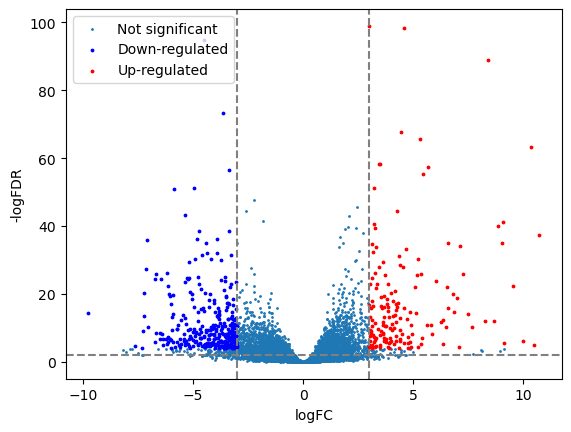

In [24]:
plt.scatter(x=full_arabi_results['log2FoldChange'],y=full_arabi_results['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")

# highlight down- or up- regulated genes
down_arabi = full_arabi_results[(full_arabi_results['log2FoldChange']<=-3)&(full_arabi_results['padj']<=0.0001)]
up_arabi = full_arabi_results[(full_arabi_results['log2FoldChange']>=3)&(full_arabi_results['padj']<=0.0001)]

plt.scatter(x=down_arabi['log2FoldChange'],y=down_arabi['padj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up_arabi['log2FoldChange'],y=up_arabi['padj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")
plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-3,color="grey",linestyle="--")
plt.axvline(3,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

In [25]:
up_arabi

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Locus,,,,,,
AT1G03070,244.041301,4.909129,0.676055,7.261436,3.830035e-13,1.623916e-11
AT1G03470,272.881762,4.077672,0.438625,9.296489,1.451593e-20,1.559438e-18
AT1G07050,78.272039,5.614861,0.772109,7.272106,3.539261e-13,1.515305e-11
AT1G07400,5542.233763,4.257430,0.479868,8.872089,7.178661e-19,6.547163e-17
AT1G08560,64.164207,3.086038,0.460190,6.706012,2.000148e-11,6.236203e-10
...,...,...,...,...,...,...
ATMG01170,114.058124,3.130845,0.402513,7.778240,7.354054e-15,3.999281e-13
ATMG01190,58.267544,5.149719,0.615456,8.367329,5.893919e-17,4.229853e-15
ATMG01200,247.691931,4.696561,0.372497,12.608320,1.899999e-36,6.931433e-34


In [26]:
up

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
LOC104645776,16.743984,5.407347,1.185733,4.560342,5.107049e-06,1.433444e-05
LOC101256908,636.987165,5.521131,0.434430,12.708905,5.276819e-37,1.509383e-35
LOC101245874,1193.548538,3.648663,0.271307,13.448487,3.142367e-41,1.126178e-39
MIR6026,348.085222,4.175639,0.238158,17.533045,8.015952e-69,8.685991e-67
JMJ524,103.081531,3.221060,0.407344,7.907461,2.626907e-15,1.976726e-14
...,...,...,...,...,...,...
CQW56_mgp29,23.900533,4.075286,0.794088,5.132033,2.866288e-07,9.469135e-07
CQW56_mgp16,115.817361,4.108246,0.454575,9.037554,1.602165e-19,1.651566e-18
CQW56_mgp11,179.570123,4.119752,0.461701,8.922987,4.538792e-19,4.524301e-18
CQW56_mgp10,81.092169,3.543048,0.562626,6.297344,3.027894e-10,1.409218e-09


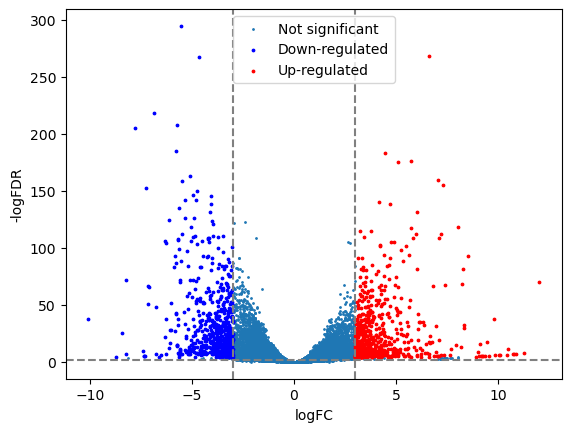

In [11]:
plt.scatter(x=full_results['log2FoldChange'],y=full_results['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")

# highlight down- or up- regulated genes
down = full_results[(full_results['log2FoldChange']<=-3)&(full_results['padj']<=0.0001)]
up = full_results[(full_results['log2FoldChange']>=3)&(full_results['padj']<=0.0001)]

plt.scatter(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")
plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-3,color="grey",linestyle="--")
plt.axvline(3,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()